In [51]:
import torch
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.style_transfer_vae import StyleTransferVAE

In [52]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda Delay"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 10
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_style_vae/ync68xdq/checkpoints/epoch=193-step=121250.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]

In [53]:
if DAFX_NAME.lower() == "clean":
    dafx = NullDAFXWrapper()
else:
    dafx = load_plugin(DAFX_FILE, plugin_name=DAFX_NAME)
    dafx = DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [54]:
dataset = PairedAudioDataset(
    dafx=dafx,
    audio_dir=AUDIO_DIR,
    subset="train",
    input_dirs=DATASETS,
    num_examples_per_epoch=NUM_EXAMPLES,
    augmentations={},
    length=131_072,
    effect_input=False,
    effect_output=True,
    dummy_setting=True
)

loader= torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=1,
    timeout=6000,
)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 24515.06it/s]


Loaded 88 files for train = 66.89 hours.


In [55]:
model = StyleTransferVAE.load_from_checkpoint(CHECKPOINT)
model.eval()

StyleTransferVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=20640, out_features=2048, bias=True)
  (log_var): Linear(in_features=2064

In [56]:
batch = next(iter(loader))
x, y = batch

In [57]:
x.shape

torch.Size([1, 1, 131072])

In [58]:
# import numpy as np
#
# def audio_to_spectrogram(signal: torch.Tensor,
#                          n_fft: int = 4096,
#                          hop_length: int = 2048,
#                          window_size: int = 4096,
#                          return_phase: bool = True):
#
#     bs, _, _ = signal.size()
#
#     window = torch.nn.Parameter(torch.hann_window(window_size))
#
#     X = torch.stft(
#             signal.view(bs, -1),
#             n_fft=n_fft,
#             hop_length=hop_length,
#             window=window,
#             return_complex=True,
#         )
#
#     # Absolute value part
#     X_db = torch.pow(X.abs() + 1e-8, 0.3)
#     X_db_norm = X_db
#
#     # Normalise (0,1)
#     X_db_norm -= 0.3352797
#     X_db_norm /= 0.2745147
#
#     X_db_norm = X_db_norm.unsqueeze(1).permute(0, 1, 3, 2)
#
#     # Angle part
#     X_phase = torch.angle(X)
#     X_phase_norm = X_phase
#
#     # Normalise (0,1)
#     X_phase_norm -= 0.0025563
#     X_phase_norm /= 1.8219221
#
#     X_phase = X_phase.unsqueeze(1).permute(0,1,3,2)
#
#     return torch.concat([X_db_norm, X_phase], dim=1)

In [42]:
def model_audio_to_spectrogram(
                             signal: torch.Tensor,
                             n_fft: int = 4096,
                             hop_length: int = 2048,
                             return_phase=True):

    bs, _, _ = signal.size()

    window = torch.nn.Parameter(torch.hann_window(4096)).to(signal.device)

    X = torch.stft(
        signal.view(bs, -1),
        n_fft=n_fft,
        hop_length=hop_length,
        window=window,
        return_complex=True,
    )

    # Absolute value part
    X_db = torch.pow(X.abs() + 1e-8, 0.3)
    X_db_norm = X_db

    # Normalise (0,1)
    X_db_norm -= 0.3352797
    X_db_norm /= 0.2745147

    X_db_norm = X_db_norm.unsqueeze(1).permute(0, 1, 3, 2)

    if not return_phase:
        return X_db_norm

    # Angle part
    X_phase = torch.angle(X)
    X_phase_norm = X_phase

    # Normalise (0,1)
    X_phase_norm -= 0.0025563
    X_phase_norm /= 1.8219221

    X_phase = X_phase.unsqueeze(1).permute(0, 1, 3, 2)

    return torch.concat([X_db_norm, X_phase], dim=1)

In [43]:
x_s = model_audio_to_spectrogram(signal=x, return_phase=True)
y_s = model_audio_to_spectrogram(signal=y, return_phase=False)

In [44]:
x_s_hat = audio_to_spectrogram(x)

In [45]:
torch.equal(x_s_hat, x_s)

True

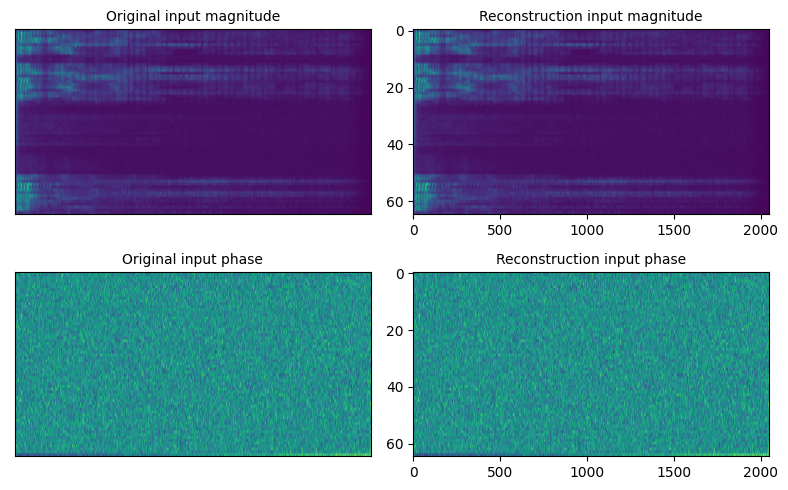

In [50]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8,5))

labels = ['input magnitude', 'input phase', 'target magnitude', 'target phase']

# find minimum of minima & maximum of maxima
# minmin = torch.min(X).item()
# maxmax = torch.max(X).item()


# for each dimension
for i in range(4):
    if i % 2 != 0:
        continue
    else:
        j = int(i/2)
    ax1 = axes[j, 0].imshow(x_s[0,j,:,:].detach().squeeze().numpy(), aspect='auto')
    ax2 = axes[j, 1].imshow(x_s_hat[0,j,:,:].detach().squeeze().numpy(), aspect='auto')


    axes[j, 0].set_title(f"Original {labels[j]}", fontsize=10)
    axes[j, 1].set_title(f"Reconstruction {labels[j]}", fontsize=10)

    axes[j, 0].set_xticks([])
    axes[j, 0].set_yticks([])

    # axes[i, 1].set_xticks([])
    # axes[i, 1].set_yticks([])

# fig.subplots_adjust(right=.85)
# cbar_ax = fig.add_axes([.9, 0.15, 0.05, 0.7])
# fig.colorbar(ax1, cax=cbar_ax)

plt.tight_layout()
# plt.savefig("./figures/spectrogram_reconstruction_lo_kld.png")
plt.show()

In [11]:
X = torch.concat([x_s, y_s], dim=1)

NameError: name 'ax2' is not defined

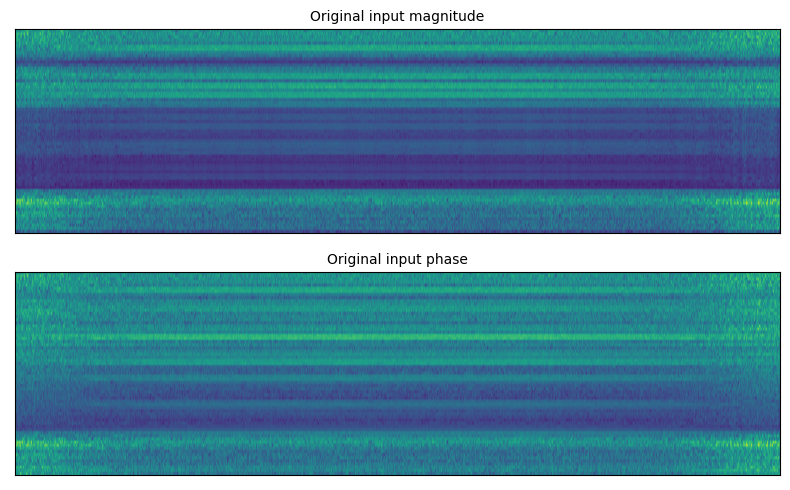

In [13]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8,5))

labels = ['input magnitude', 'input phase', 'target magnitude', 'target phase']

# find minimum of minima & maximum of maxima
minmin = torch.min(X).item()
maxmax = torch.max(X).item()

# for each dimension
for i in range(2):
    ax1 = axes[i].imshow(X[0,i,:,:].detach().squeeze().numpy(), aspect='auto', vmin=minmin, vmax=maxmax)
    # ax2 = axes[i, 1].imshow(X_hat[0,i,:,:].detach().squeeze().numpy(), aspect='auto', vmin=minmin, vmax=maxmax)

    axes[i].set_title(f"Original {labels[i]}", fontsize=10)
    # axes[i, 1].set_title(f"Reconstruction {labels[i]} (MSE: {mse.item():.4f})", fontsize=10)

    axes[i].set_xticks([])
    axes[i].set_yticks([])

    # axes[i, 1].set_xticks([])
    # axes[i, 1].set_yticks([])

# fig.subplots_adjust(right=.85)
# cbar_ax = fig.add_axes([.9, 0.15, 0.05, 0.7])
# fig.colorbar(ax1, cax=cbar_ax)

plt.tight_layout()
# plt.savefig("./figures/spectrogram_reconstruction_lo_kld.png")
plt.colorbar(ax2)
plt.show()

In [29]:
X.shape

In [30]:
X_hat, _, _, z = model(X)

In [31]:
X_hat.shape

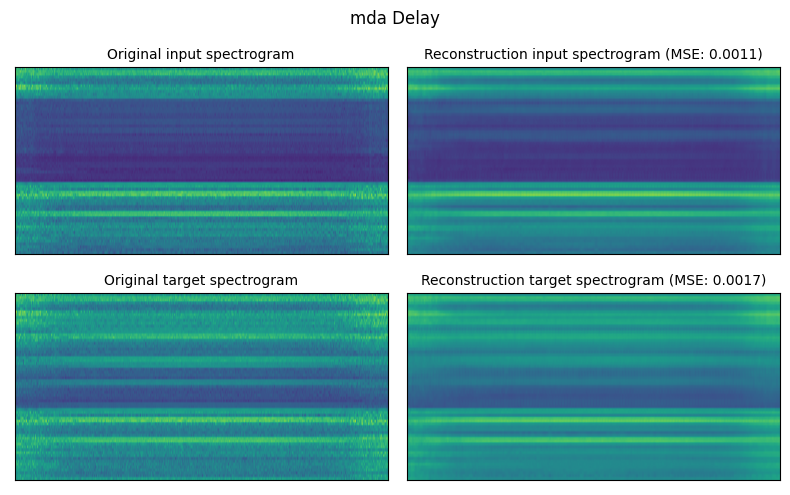

In [13]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8,5))

labels = ['input spectrogram', 'target spectrogram']

# find minimum of minima & maximum of maxima
minmin = min([torch.min(X).item(), torch.min(X_hat).item()])
maxmax = max([torch.max(X).item(), torch.max(X_hat).item()])

# for each dimension
for i in range(2):
    mse = F.mse_loss(X[0,i,:,:], X_hat[0,i,:,:])

    ax1 = axes[i, 0].imshow(X[0,i,:,:].detach().squeeze().numpy(),
                            aspect='auto',
                            vmin=minmin,
                            vmax=maxmax)

    ax2 = axes[i, 1].imshow(X_hat[0,i,:,:].detach().squeeze().numpy(),
                            aspect='auto',
                            vmin=minmin,
                            vmax=maxmax)

    axes[i, 0].set_title(f"Original {labels[i]}", fontsize=10)
    axes[i, 1].set_title(f"Reconstruction {labels[i]} (MSE: {mse.item():.4f})", fontsize=10)

    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])


# plt.savefig("./figures/spectrogram_reconstruction_lo_kld.png")

# add space for colour bar
fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(ax2, cax=cbar_ax)
fig.suptitle(DAFX_NAME)

plt.tight_layout()
plt.savefig(f"./figures/{CHECKPOINT_ID}_{DAFX_NAME.split()[-1].lower()}_joint_reconstruction_2dafx.svg")